Training the LightGBM model with SMOTE...
[LightGBM] [Info] Number of positive: 137245, number of negative: 137245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7902
[LightGBM] [Info] Number of data points in the train set: 274490, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training complete.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM Model Evaluation Results ---
ROC AUC Score: 0.7484

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     34311
         1.0       0.58      0.07      0.13      4502

    accuracy                           0.89     38813
   macro avg       0.74      0.53      0.54     38813
weighted avg       0.86      0.89      0.85     38813



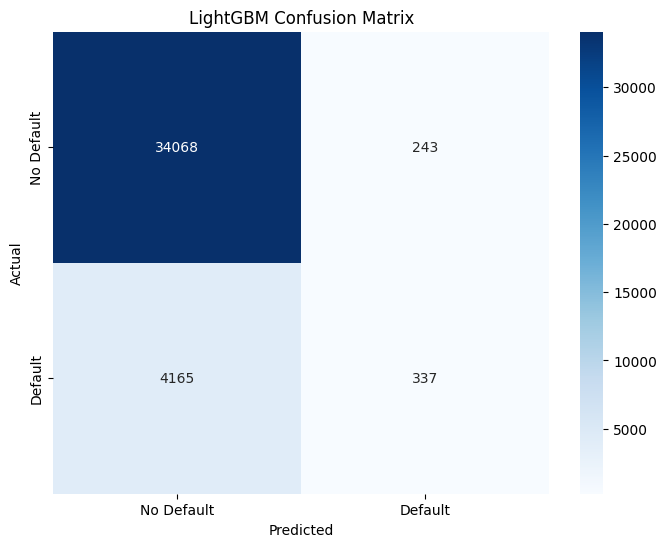

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

try:
    # --- 1. Load and Clean Data ---
    df = pd.read_csv('Loan_default.csv')
    df.dropna(inplace=True) # Clean data just in case

    # --- 2. Data Preparation ---
    X = df.drop(columns=['LoanID', 'Default'])
    y = df['Default']

    # Define feature types
    categorical_features = X.select_dtypes(include=['object']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- 3. Preprocessing and Model Pipeline ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    # Create the LightGBM Classifier model
    lgbm_model = lgb.LGBMClassifier(random_state=42)

    # Create the full pipeline with SMOTE
    model_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', lgbm_model)
    ])

    # --- 4. Train the Model ---
    print("Training the LightGBM model with SMOTE...")
    model_pipeline.fit(X_train, y_train)
    print("Training complete.")

    # --- 5. Evaluate the Model ---
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("\n--- LightGBM Model Evaluation Results ---")
    print(f"ROC AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(report)

    # --- 6. Visualization ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title('LightGBM Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


except FileNotFoundError:
    print("Error: Loan_default.csv not found.")
except ImportError:
    print("Error: A required library is not installed.")
    print("Please run: pip install lightgbm scikit-learn pandas matplotlib seaborn imbalanced-learn")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
Analysis of the LightGBM Results

Critically Low Recall (7%): The model only correctly identifies 7% of all actual loan defaults. This means it misses 93% of the risky loans, making it unreliable for risk management.

Precision (58%): While the precision is slightly better than XGBoost, it is irrelevant because the model flags so few defaulters in the first place.

High Accuracy (89%): As with the previous model, this high accuracy is misleading. It's only high because the model overwhelmingly predicts the majority class ("No Default"), which is the easiest but least useful prediction.